In [100]:
import shap
import pandas as pd
import scipy as sp
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from treeinterpreter.feature_importance import feature_importance as FI
import multiprocessing as mp

# Compare different methods in terms of feature pruning performance

### load data

In [2]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
         'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label']
df_train = pd.read_csv('../data/adult/adult.data', header=None, names=names, index_col=False)
print(df_train.shape)
df_train.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df_test = pd.read_csv('../data/adult/adult.test', index_col=False, header=None, skiprows=1, names=names)
df_test.head()
print(df_test.shape)

(16281, 15)


### Preprocessing

In [4]:
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


- replace ' ?' to null 

In [5]:
df_train = df_train.replace(' ?', np.NaN)
df_test = df_test.replace(' ?', np.NaN)

- Drop noncomplete rows

In [6]:
df_train = df_train.dropna()
df_test = df_test.dropna()
print(df_train.shape, df_test.shape)

(30162, 15) (15060, 15)


- Make the label of test set and train set the same

In [7]:
df_test['label'].unique(), df_train['label'].unique()

(array([' <=50K.', ' >50K.'], dtype=object),
 array([' <=50K', ' >50K'], dtype=object))

In [8]:
df_test['label'] = [x[:-1] for x in df_test['label']]

In [9]:
df_test['label'].unique(), df_train['label'].unique()

(array([' <=50K', ' >50K'], dtype=object),
 array([' <=50K', ' >50K'], dtype=object))

- Drop education because it duplicates education_num. Because of that, in Gini importance, it is not zero, in MDI, it is zero.

In [67]:
stacked = df_train.copy()
stacked = stacked.append(df_test)
stacked = stacked.drop('education', axis=1)
names = list(stacked.columns)

- one hot encoding

In [68]:
tmp = pd.get_dummies(stacked)
feature_names = list(tmp.columns)[:-2]
df_train_one_hot = tmp.iloc[:df_train.shape[0], :]
df_test_one_hot = tmp.iloc[df_train.shape[0]:, :]
X_train = np.array(df_train_one_hot.iloc[:, :-2])
y_train = np.array(df_train_one_hot.iloc[:, -1])
X_test = np.array(df_test_one_hot.iloc[:, :-2])
y_test = np.array(df_test_one_hot.iloc[:, -1])

### Train RF

In [69]:
rf = rfc(n_estimators=100, max_depth=20)
rf.fit(X_train, y_train)
gini_imp = rf.feature_importances_

- accuracy

In [70]:
print('accuracy of RF is {0:.3f}'.format(accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))))

accuracy of RF is 0.863


- Plot feature importance

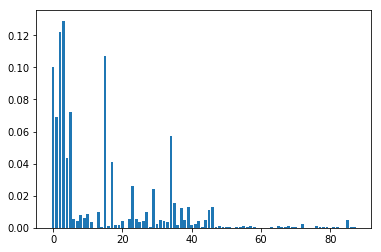

In [14]:
plt.bar(x = np.arange(X_train.shape[1]), height = gini_imp)
plt.show()

### prune features based on their importance measures

- classic gini importance

In [15]:
def aggregate_feature_importance(importances, names, feature_names):
    agg_feature_imp = np.zeros((len(names), ))
    for j, long_name in enumerate(feature_names):
        for i, name in enumerate(names):
            if name in long_name:
                agg_feature_imp[i] += importances[j]
    return agg_feature_imp

In [16]:
def distribute_rank(ranks, names, feature_names):
    out = np.zeros((len(feature_names),))
    for j, long_name in enumerate(feature_names):
        for i, name in enumerate(names):
            if name in long_name:
                out[j] = ranks[i]
    return out

     - plot the gini importance

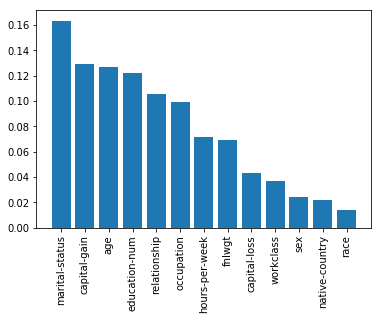

In [17]:
gini_agg_imp = aggregate_feature_importance(gini_imp, names[:-1], feature_names)
ix = np.argsort(gini_agg_imp * -1)
plt.bar(x = list(range(13)), height = gini_agg_imp[ix])
plt.xticks(list(range(13)), np.array(names[:-1])[ix], rotation='vertical')
plt.show()

- debiased gini importance

In [18]:
debiased_fi_mean, debiased_fi_std = FI(rf, X_train, np.array(df_train_one_hot.iloc[:, -2:]), type='oob', normalized=False)

    - plot debiased gini importance

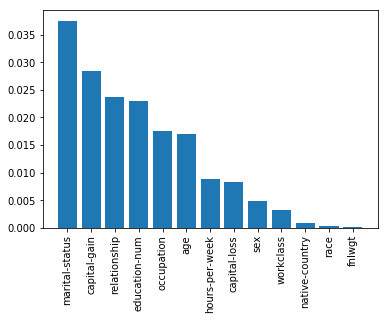

In [19]:
debiased_agg_imp = aggregate_feature_importance(debiased_fi_mean, names[:-1], feature_names)
ix = np.argsort(debiased_agg_imp * -1)
plt.bar(x = list(range(13)), height = debiased_agg_imp[ix])
plt.xticks(list(range(13)), np.array(names[:-1])[ix], rotation='vertical')
plt.show()

- MDA

In [20]:
def MDA(rf, 
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        mask, 
        n_trials = 1):
    
    n_features = len(mask)
    n_groups = int(max(mask)) + 1
    scores = np.zeros((n_groups,))
    best_score = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
    for _ in range(n_trials):
        for i in range(n_groups):
            tmp = X_test.copy()
            tmp[:, mask == i] = np.random.permutation(tmp[:, mask == i])
            score = accuracy_score(y_true=y_test, y_pred=rf.predict(tmp))
            scores[i] += best_score - score
    return scores / n_trials

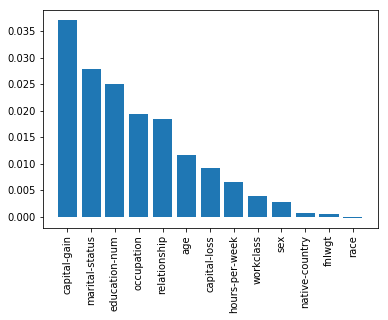

In [21]:
mask = distribute_rank(list(range(14)), names, feature_names)
MDA_agg_imp = MDA(rf, X_train, y_train, X_test, y_test, mask, n_trials=4)
ix = np.argsort(MDA_agg_imp * -1)
plt.bar(x = list(range(13)), height = MDA_agg_imp[ix])
plt.xticks(list(range(13)), np.array(names[:-1])[ix], rotation='vertical')
plt.show()

- tree SHAP

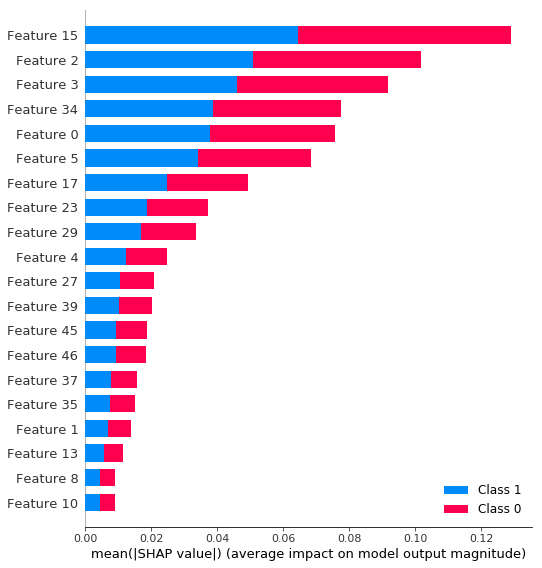

In [45]:
explainer = shap.TreeExplainer(rf)
samples = np.random.choice(range(X_train.shape[0]), 100)
shap_values = explainer.shap_values(X_train[samples, :])
shap.summary_plot(shap_values, X_train[samples, :], plot_type="bar")

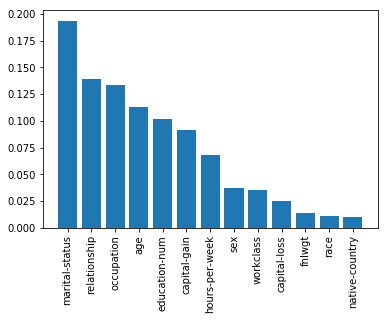

In [46]:
shap_imp = np.mean(abs(shap_values[0]), 0) + np.mean(abs(shap_values[1]), 0)
shap_agg_imp = aggregate_feature_importance(shap_imp, names[:-1], feature_names)
ix = np.argsort(shap_agg_imp * -1)
plt.bar(x = list(range(13)), height = shap_agg_imp[ix])
plt.xticks(list(range(13)), np.array(names[:-1])[ix], rotation='vertical')
plt.show()

### Comparison

In [86]:
def rank_correlation(x, y):
    return sp.corrcoef(sp.stats.rankdata(x), sp.stats.rankdata(y))[0,1]

- In terms of correlation with MDA

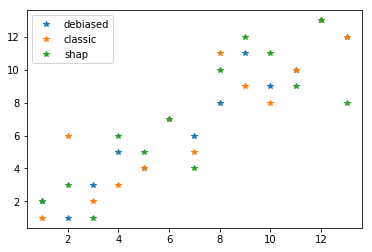

In [52]:
plt.plot(sp.stats.rankdata(MDA_agg_imp[ix]), sp.stats.rankdata(debiased_agg_imp[ix]), '*')
plt.plot(sp.stats.rankdata(MDA_agg_imp[ix]), sp.stats.rankdata(gini_agg_imp[ix]), '*')
plt.plot(sp.stats.rankdata(MDA_agg_imp[ix]), sp.stats.rankdata(shap_agg_imp[ix]), '*')
plt.legend(['debiased', 'classic', 'shap'])
plt.show()

In [87]:
rank_correlation(MDA_agg_imp, debiased_agg_imp)

0.9615384615384615

In [88]:
rank_correlation(MDA_agg_imp, gini_agg_imp)

0.8901098901098902

In [89]:
rank_correlation(MDA_agg_imp, shap_agg_imp)

0.8241758241758241

    - how accuracy decreases if we permute the feature from the least important to the most important

In [147]:
def plot_accuracy_drop(rf, X_test, y_test, feature_imp, names, feature_names):
    imp_ranking = distribute_rank(sp.stats.rankdata(feature_imp) - 1, names, feature_names)
    a = mp.Pool(mp.cpu_count() // 2)
    tmp = np.array([a.apply(MDA_consecutive, args = (rf, X_test, y_test, imp_ranking, i)) for i in range(8)])
    scores = np.mean(tmp, 0)
    std = np.std(tmp, 0) / tmp.shape[0] ** .5
    a.close()
    #scores = MDA_consecutive(rf, X_test, y_test, imp_ranking, n_trials=4)
    plt.errorbar(x=list(range(len(scores))), y=scores, yerr=std)
    plt.xticks(list(range(len(scores))), np.array(names), rotation='vertical')

In [148]:
def MDA_consecutive(rf, 
                    X_test, 
                    y_test, 
                    mask,
                    seed = None,
                    n_trials = 1):
    
    n_features = len(mask)
    np.random.seed(seed)
    n_groups = len(np.unique(mask))
    assert n_groups == max(mask) + 1
    scores = np.zeros((n_groups,))
    best_score = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
    tmp = X_test.copy()
    for _ in range(n_trials):
        for i in range(n_groups):
            tmp[:, mask == i] = np.random.permutation(tmp[:, mask == i])
            score = accuracy_score(y_true=y_test, y_pred=rf.predict(tmp))
            scores[i] += score - best_score
    return scores / n_trials

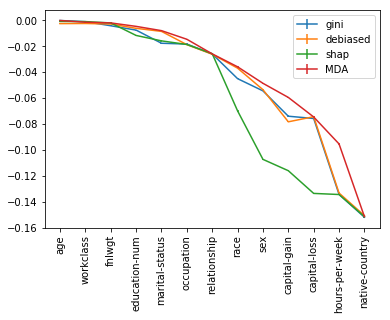

In [149]:
plot_accuracy_drop(rf, X_test, y_test, gini_agg_imp, names[:-1], feature_names)
plot_accuracy_drop(rf, X_test, y_test, debiased_agg_imp, names[:-1], feature_names)
plot_accuracy_drop(rf, X_test, y_test, shap_agg_imp, names[:-1], feature_names)
plot_accuracy_drop(rf, X_test, y_test, MDA_agg_imp, names[:-1], feature_names)
plt.legend(['gini', 'debiased', 'shap', 'MDA'])